In [ ]:
#Este exemplo gera isofotas elípticas através da classe ELLIPSE
#Criado por Oscar Cavichia
#Curso de Astrofísica Extragaláctica
#Universidade Federal de Itajubá

import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

In [ ]:
!pip3 install photutils
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture
from photutils.isophote import Ellipse
from photutils.isophote import build_ellipse_model

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


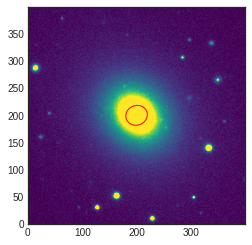

In [44]:
#Substituir a imagem abaixo pela sua
imageFile = "/NGC0777_SDSSr.fits"

hdul = fits.open(imageFile)
#hdul.info()
hdu=fits.open(imageFile)[0]
image_data=hdu.data
wcs = WCS(hdu.header)

#Verificar no ds9 as coordenadas x0 e y0 da galáxia e mudar os valores:
position = (1203, 1071)
size = (400, 400)

cutout = Cutout2D(image_data, position=position, size=size, wcs=wcs)
image_data_cut = cutout.data

plt.imshow(image_data_cut, origin='lower', cmap='viridis', vmin=0,vmax=1)

#Caso mude os valores de size, substituir x0 e y0 abaixo pela metade dos valores
geometry = EllipseGeometry(x0=200, y0=200, sma=20, eps=0.1,
                           pa=20.*np.pi/180.)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps), geometry.pa)
#plt.imshow(image_data_cut, origin='lower')
aper.plot(color='red')

#Criamos uma instancia da classe Ellipse para fazer o ajuste de isofotas elípticas
ellipse = Ellipse(image_data_cut, geometry)

#Fazemos o ajuste da elípse com o método fit_image. Não ajustamos em menos de 2 pixels.
isolist = ellipse.fit_image(minsma=2)

#O resultado é o objeto isolist que contem os atributos:
#https://photutils.readthedocs.io/en/stable/api/photutils.isophote.IsophoteList.html#photutils.isophote.IsophoteList

In [19]:
#Vamos imprimir os semieixos das isofotas 
print(isolist.sma)

[  0.           0.53469726   0.58816699   0.64698369   0.71168205
   0.78285026   0.86113529   0.94724881   1.0419737    1.14617107
   1.26078817   1.38686699   1.52555369   1.67810906   1.84591996
   2.03051196   2.23356316   2.45691947   2.70261142   2.97287256
   3.27015982   3.5971758    3.95689338   4.35258272   4.78784099
   5.26662509   5.79328759   6.37261635   7.00987799   7.71086579
   8.48195237   9.3301476   10.26316236  11.2894786   12.41842646
  13.66026911  15.02629602  16.52892562  18.18181818  20.
  22.          24.2         26.62        29.282       32.2102
  35.43122     38.974342    42.8717762   47.15895382  51.8748492
  57.06233412  62.76856753  69.04542429  75.94996672  83.54496339
  91.89945973 101.0894057  111.19834627 122.3181809  134.54999899
 148.00499889 162.80549877]


In [31]:
#Os nomes de cada coluna são:
print(isolist.get_names())

['sma', 'intens', 'int_err', 'eps', 'ellip_err', 'pa', 'pa_err', 'x0', 'x0_err', 'y0', 'y0_err', 'rms', 'pix_stddev', 'grad', 'grad_error', 'grad_r_error', 'sarea', 'ndata', 'nflag', 'niter', 'valid', 'stop_code', 'tflux_e', 'tflux_c', 'npix_e', 'npix_c', 'a3', 'b3', 'a4', 'b4', 'a3_err', 'b3_err', 'a4_err', 'b4_err']


In [32]:
#Podemos imprimir uma tabela ordenada por sma:
print(isolist.to_table())
#Vamos salvar a tabela em uma arquivo txt
from tabulate import tabulate
with open('dados_ajuste.txt', 'w') as f:
    f.write(tabulate(isolist.to_table()))


       sma                intens        ... niter stop_code
                                        ...                
------------------ -------------------- ... ----- ---------
 2.030511959895411    29.03825808294804 ...    10         0
2.2335631558849522    28.13590477240464 ...    10         0
2.4569194714734475    27.13675477093988 ...    50         2
2.7026114186207923    25.99123927728753 ...    10         0
 2.972872560482872    24.60011823835625 ...    10         0
 3.270159816531159   23.250119161703815 ...    10         0
 3.597175798184275      21.815581241104 ...    10         0
 3.956893378002703   20.287989964074175 ...    11         0
 4.352582715802973   18.798120448904907 ...    10         0
  4.78784098738327   17.334852547352362 ...    10         0
               ...                  ... ...   ...       ...
 69.04542428786206   0.3600630306065608 ...    10         0
 75.94996671664828  0.29581655434752574 ...    10         0
  83.5449633883131  0.24113556148670712 

Text(0.5, 1.0, 'Residuo')

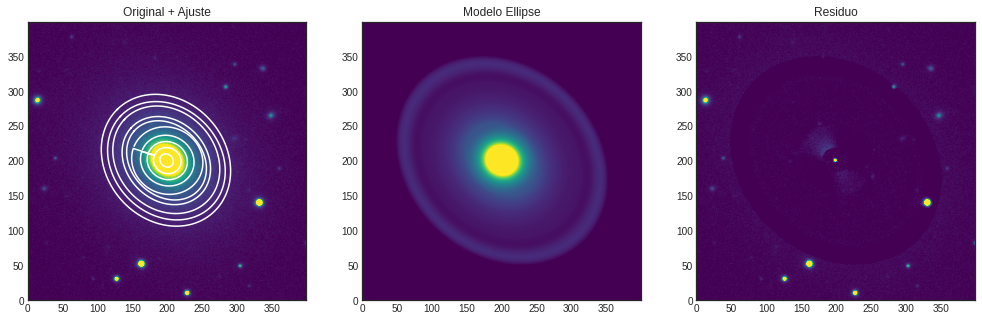

In [42]:
#Construir uma imagem do modelo

model_image = build_ellipse_model(image_data_cut.shape, isolist)
residual = image_data_cut - model_image

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(image_data_cut, origin='lower',cmap='viridis',vmin=0,vmax=2)
ax1.set_title('Original + Ajuste')

smas = np.linspace(10, 100, 10)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white')

ax2.imshow(model_image, origin='lower',cmap='viridis',vmin=0,vmax=2)
ax2.set_title('Modelo Ellipse')

ax3.imshow(residual, origin='lower',cmap='viridis',vmin=0,vmax=2)
ax3.set_title('Residuo')